# Introduction to VoxelMorph
[Adrian Dalca](http://adalca.mit.edu) and Andrew Hoopes    
Introductory slides for this tutorial are [here](https://github.com/learn2reg/tutorials2019/blob/master/slides/Learn2reg_tutorial_unsupervided_AdrianDalca.pdf).

This is a short tutorial to get you started with [VoxelMorph](https://github.com/voxelmorph/voxelmorph): deep-learning based registration.

### Outline
- **Core concepts with MNIST**   
We will first learn to deal with data, building a model, training, registration and generalization
- **More realistic complexity: Brain MRI (2D slices)**  
We will then show how these models work for 2d slices of brain scans, presenting a more complex scenario    
- **Realistic 3D Brain MRI**  
We will illustrate full 3D registration
- **Advances topics**  
Finally, we close with more advanced topics, including diffeomorphisms and fine-tuning deformations

Throughout this tutorial we assume that the images have been rigidly aligned in a (roughly) similar space.  
Rigid alignment is also possible with VoxelMorph, but it's not our focus here.  A separate tutorial is being designed for that


### References
[VoxelMorph at TMI](https://arxiv.org/abs/1809.05231)   
[Diffeomorphic VoxelMorph at MedIA](https://arxiv.org/abs/1903.03545)   
[Neurite Library](https://github.com/adalca/neuron) - [CVPR](http://arxiv.org/abs/1903.03148)

---

# Preamble
## Setup of environment

In [ ]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph

We'll start with some common imports  

In [ ]:
# imports
import os, sys

# third party imports
import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

Next, we import two packages that will help us   
- [voxelmorph](http://voxelmorph.mit.edu) is a deep-learning based registration library  
- [neurite](https://github.com/adalca/neurite) is a library for medical image analysis with tensorflow  

In [ ]:
# local imports
import voxelmorph as vxm
import neurite as ne

---

# Data

We're going to start by registering 2D MNIST digits, and then move on to medical data later. If the data is small (like 2D MNIST), you can often load it in memory, which enables for faster training and testing. If the data is large (large 3D scans), we will likely need to load the scans on demand. More on this later.

First, we're going to **load the data**. Luckily, MNIST comes with the keras framework, so we can just load it here



In [ ]:
# You should most often have this import together with all other imports at the top,
# but we include here here explicitly to show where data comes from
from tensorflow.keras.datasets import mnist

In [ ]:
# load MNIST data.
# `mnist.load_data()` already splits our data into train and test.
(x_train_load, y_train_load), (x_test_load, y_test_load) = mnist.load_data()

digit_sel = 5

# extract only instances of the digit 5
x_train = x_train_load[y_train_load==digit_sel, ...]
y_train = y_train_load[y_train_load==digit_sel]
x_test = x_test_load[y_test_load==digit_sel, ...]
y_test = y_test_load[y_test_load==digit_sel]

# let's get some shapes to understand what we loaded.
print('shape of x_train: {}, y_train: {}'.format(x_train.shape, y_train.shape))

shape of x_train: (5421, 28, 28), y_train: (5421,)


**ML detour**: separating your data in *only* train/test **often leads to problems**   
You wouldn't want to iteratively (A) build a model, (B) train on training data, and (C) test on test data  
Doing so will **overfit to you test set** (because you will have adapted your algorithm to your test data). It's a common mistakes in ML submissions.  

We will split the 'training' into 'train/validate' data, and keep the test set for later  
And will only look at the test data at the very end (once we're ready to submit the paper!)  

In [ ]:
nb_val = 1000  # keep 1,000 subjects for validation
x_val = x_train[-nb_val:, ...]  # this indexing means "the last nb_val entries" of the zeroth axis
y_val = y_train[-nb_val:]
x_train = x_train[:-nb_val, ...]
y_train = y_train[:-nb_val]

### Visualize Data

When we are done loading, it's always great to visualize the data  
Here, we use some tools from a package called `neurite`, which uses matplotlib  
You could use matplotlib as well directly, but it would just be a bit messier  
and here we want to illustrate the main concepts.  

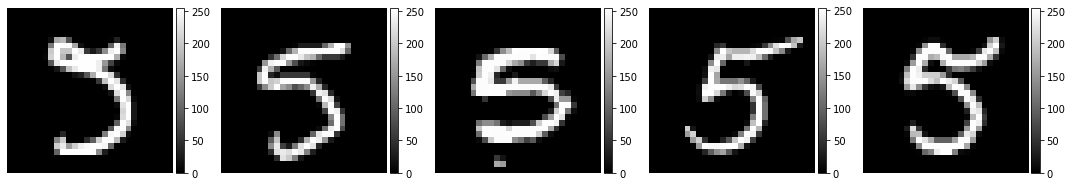

In [ ]:
nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_digits = [f for f in x_train[idx, ...]]

# plot
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

Looks good!  

However, luckily we included a **colorbar**, which shows us that the data is in [0, 255].  
In neural networks it's often great to work in the ranges of [0, 1] or [-1, 1] or around there.  
Let's fix this.

In general, you should always plot your data with colorbars, which helps you catch issues before training  

In [ ]:
# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

training maximum value 1.0


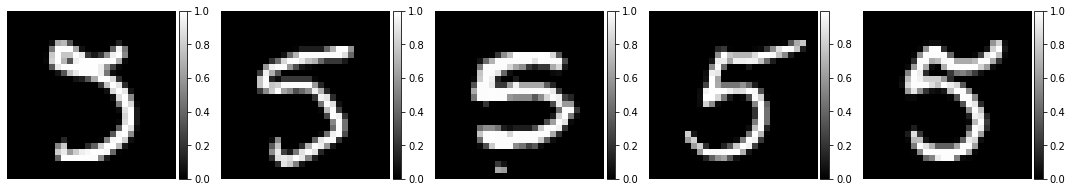

In [ ]:
# re-visualize
example_digits = [f for f in x_train[idx, ...]]
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

One last change. Later on, we'll see that some of the most popular models like to have inputs that are sized as multiples of 2^N for N being the number of layers. Here, we force our images to be size 32 (2x 2^4).

In [ ]:
pad_amount = ((0, 0), (2,2), (2,2))

# fix data
x_train = np.pad(x_train, pad_amount, 'constant')
x_val = np.pad(x_val, pad_amount, 'constant')
x_test = np.pad(x_test, pad_amount, 'constant')

# verify
print('shape of training data', x_train.shape)

shape of training data (4421, 32, 32)


---

# CNN Model

Given two images (which we call *moving* and *fixed*), our goal is to find the deformation between them. In learning-based methods, we use a network that takes in two images $m$ ("moving") and $f$ ("fixed") (e.g. MNIST digits of size 32x32) and outputs a dense deformation $\phi$ (e.g. size 32x32x2, because at each pixel we want a vector telling us where to go). Intuitively, this deformation $\phi$ gives us the correspondances between the images, and tells us how to moving the moving image to match up with the fixed image.

**Note**: Registration also includes (or refers to) affine transforms, but we ignore that here.

The [VoxelMorph](http://voxelmorph.mit.edu) library provides a `VxmDense` model class for building dense deformation networks. We will discuss this class later on, but for tutorial sake, we'll start by building this model from scratch in order to demonstrate the individual components of the network. First, we're going to abstract the UNet and with the `vxm.networks.Unet()` model.

In [ ]:
# configure unet input shape (concatenation of moving and fixed images)
ndim = 2
unet_input_features = 2
inshape = (*x_train.shape[1:], unet_input_features)

# configure unet features
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model
unet = vxm.networks.Unet(inshape=inshape, nb_features=nb_features)

Let's explore the model bit...

In [ ]:
print('input shape: ', unet.input.shape)
print('output shape:', unet.output.shape)

input shape:  (None, 32, 32, 2)
output shape: (None, 32, 32, 16)


Now we need to make sure the final output has 2 features, representing the deformation at each voxel.

In [ ]:
# transform the results into a flow field.
disp_tensor = tf.keras.layers.Conv2D(ndim, kernel_size=3, padding='same', name='disp')(unet.output)

# check tensor shape
print('displacement tensor:', disp_tensor.shape)

# using keras, we can easily form new models via tensor pointers
def_model = tf.keras.models.Model(unet.inputs, disp_tensor)

displacement tensor: (None, 32, 32, 2)


The deformation model `def_model` will now *share layers* with the UNet model, so if we change layer weights in `unet`, they change in `def_model`.

### Loss

Given that the displacement $\phi$ is output from the network,  
we need to figure out a loss to tell if it makes sense

In a **supervised setting** we would have ground truth deformations $\phi_{gt}$,  
and we could use a supervised loss like MSE $= \| \phi - \phi_{gt} \|$

The main idea in **unsupervised registration** is to use loss inspired by classical registration  

Without supervision, how do we know this deformation is good?  
(1) make sure that $m \circ \phi$ ($m$ warped by $\phi$) is close to $f$  
(2) regularize $\phi$ (often meaning make sure it's smooth)  

To achieve (1), we need to *warp* input image $m$. To do this, we use a spatial transformation network layer, which essentially does linear interpolation.

In [ ]:
# build transformer layer
spatial_transformer = vxm.layers.SpatialTransformer(name='transformer')

# extract the first frame (i.e. the "moving" image) from unet input tensor
moving_image = tf.expand_dims(unet.input[..., 0], axis=-1)

# warp the moving image with the transformer
moved_image_tensor = spatial_transformer([moving_image, disp_tensor])

Instructions for updating:
Use fn_output_signature instead


To make sure the moved image is close to the fixed image, and to achieve smoothness loss of $\phi$ in (2), we will want these two as outputs from the full model.

In [ ]:
outputs = [moved_image_tensor, disp_tensor]
vxm_model = tf.keras.models.Model(inputs=unet.inputs, outputs=outputs)

The model we just created represents the standard, dense VoxelMorph archetecture, with a UNet component, displacement field, and final spatial transformer layer. However, you don't have to build this model from scratch every time - the VoxelMorph library provides a highly customizable `VxmDense` model class that encompasses this archetecture.

From now on in the tutorial, we will be using `VxmDense` class to build models, so let's rebuild the equivolent network.

In [ ]:
# build model using VxmDense
inshape = x_train.shape[1:]
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

The `int_steps=0` option disables diffeomorphism, which will be covered in a more advanced tutorial.

It's worth noting that the `VxmDense` model is automatically configured with two input tensors (moving and fixed inputs) instead of one. The input shape parameter should not contain any feature information, which can be set via the optional `src_feats` and `trg_feats` parameters.

Let's take one final look at the model.

In [ ]:
print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

input shape:  (None, 32, 32, 1), (None, 32, 32, 1)
output shape: (None, 32, 32, 1), (None, 32, 32, 2)


Now that've learned how to easily build our networks, let's define the actual loss. The way keras works, we need to define a loss for each output.    
The first loss is easy, it's simply MSE between the warped image $m \circ \phi$.
For the second, we will use a spatial gradient of the displacement.  
We won't code this from scratch here, but we'll use the `voxelmorph` implementation.

In [ ]:
# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

Finally, we can compile the model.
This sets up the model for training, by associating the model with a loss and an optimizer

In [ ]:
vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

# Train Model

To train, we need to make sure the data is in the right format and fed to the model the way we want it keras models can be trained with `model.fit`, which requires all the data to be in a big array, or `model.fit_generator`, which requires a python generator that gives you batches of data.

Let's code a simple data generator based on the MNIST data.

In [ ]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)

    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ..., np.newaxis]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ..., np.newaxis]
        inputs = [moving_images, fixed_images]

        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare
        # the resulting moved image with the fixed image.
        # we also wish to penalize the deformation field.
        outputs = [fixed_images, zero_phi]

        yield (inputs, outputs)

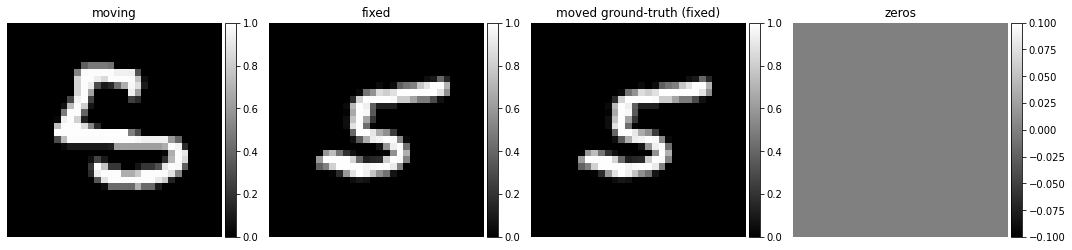

In [ ]:
# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [ ]:
nb_epochs = 10
steps_per_epoch = 100
hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 - 32s - loss: 0.0566 - transformer_loss: 0.0537 - flow_loss: 0.0572
Epoch 2/10
100/100 - 30s - loss: 0.0250 - transformer_loss: 0.0196 - flow_loss: 0.1092
Epoch 3/10
100/100 - 30s - loss: 0.0194 - transformer_loss: 0.0141 - flow_loss: 0.1053
Epoch 4/10
100/100 - 30s - loss: 0.0170 - transformer_loss: 0.0119 - flow_loss: 0.1021
Epoch 5/10
100/100 - 30s - loss: 0.0150 - transformer_loss: 0.0102 - flow_loss: 0.0963
Epoch 6/10
100/100 - 30s - loss: 0.0141 - transformer_loss: 0.0093 - flow_loss: 0.0950
Epoch 7/10
100/100 - 30s - loss: 0.0134 - transformer_loss: 0.0087 - flow_loss: 0.0929
Epoch 8/10
100/100 - 30s - loss: 0.0126 - transformer_loss: 0.0081 - flow_loss: 0.0901
Epoch 9/10
100/100 - 30s - loss: 0.0116 - transformer_loss: 0.0072 - flow_loss: 0.0877
Epoch 10/10
100/100 - 30s - loss: 0.0116 - transformer_loss: 0.0072 - flow_loss: 0.0870


It's always a good idea to visualize the loss, not just read off the numbers. This will give us a better idea of whether it's converged, etc. Tensorflow offers a powerful interactive system for visualizing called tensorboard. For this short tutorial, we will simply plot the loss.

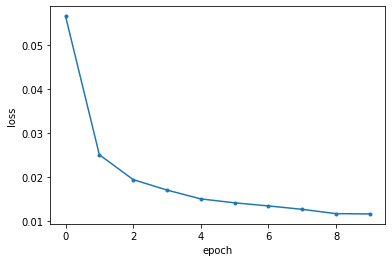

In [ ]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

Clearly, this is not converged, and you should run it to convergence, but for the purposes of this tutorial, we'll move on.

# Registration

With pair-wise optimization methods (like most classical methods), to register a new pair you would need to optimize a deformation field.  

With learning based registration, we simply evaluate the network for a new input pair  

In [ ]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

*Registration*: `predict()` essentially executes the network given an input.

In [ ]:
val_pred = vxm_model.predict(val_input)

and that's it!

Even though this is on MNIST only, let's see how long this takes

In [ ]:
# %timeit is a 'jupyter magic' that times the given line over several runs
%timeit vxm_model.predict(val_input)

10 loops, best of 3: 41.9 ms per loop


~3 ms per registration is quite fast, even for MNIST. Let's visualize the results.

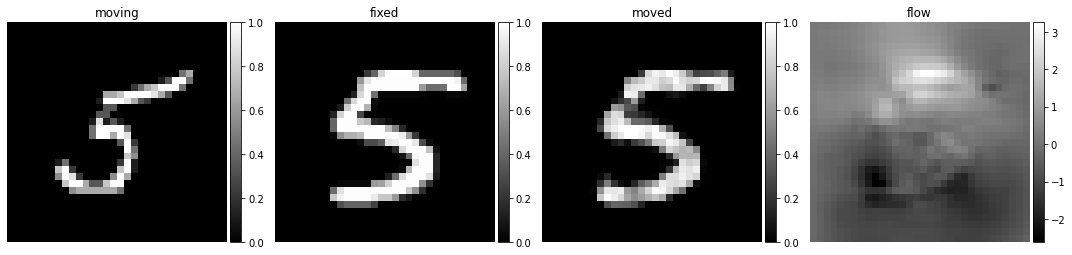

In [ ]:
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Let's visualize the flow a bit better.

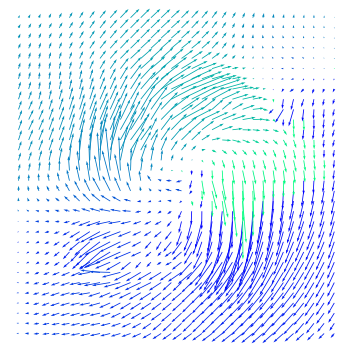

In [ ]:
ne.plot.flow([val_pred[1].squeeze()], width=5);

# Generalization
How do learning-based methods generalize beyond training distribution ?

An important caveat to learning-based registration is that they will, in general, only register samples fromt he distribution they've been trained from.

So, what happens if we register two 7's?

In [ ]:
# extract only instances of the digit 7
x_sevens = x_train_load[y_train_load==7, ...].astype('float') / 255
x_sevens = np.pad(x_sevens, pad_amount, 'constant')

# predict
seven_generator = vxm_data_generator(x_sevens, batch_size=1)
seven_sample, _ = next(seven_generator)
seven_pred = vxm_model.predict(seven_sample)

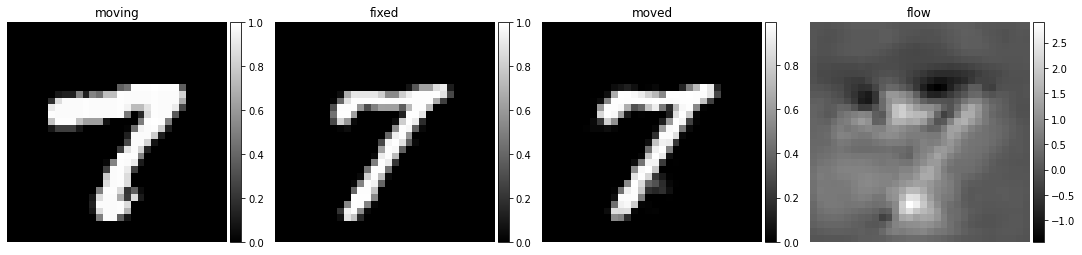

In [ ]:
# visualize
images = [img[0, :, :, 0] for img in seven_sample + seven_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Interesting - it still works! So it **generalized beyond what we expected**. Why? Locally, parts of the 7s look similar to the 5s, so the  registration algorithm still tries to match local neighborhoods.

Let's try a different variation. What if we just modify the (original) set, but multiplied the intensities by a factor?

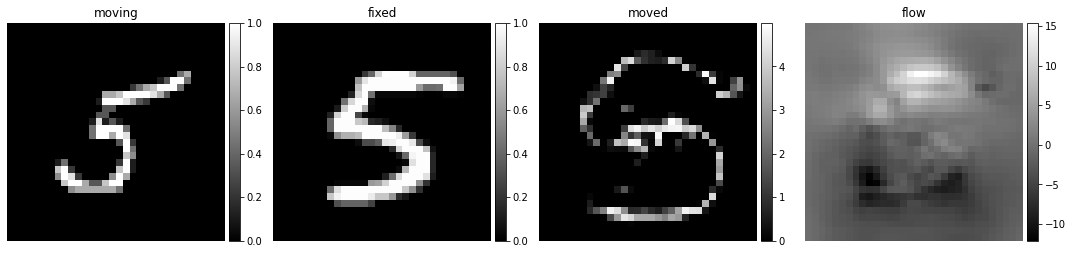

In [ ]:
factor = 5
val_pred = vxm_model.predict([f * factor for f in val_input])

# visualizeb
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

This broke down! Why? In this case, the network has never seen even parts of this image.

Understanding when the network generalizes and when it does not is very important, and still a part of active research.

# Registration of Brain MRI

We will now register slightly more realistic data - MRIs of the brain.  To be able to train and easily register during this tutorial, we will first extract the middle slice of brain scans.

Note that because this task does not capture deformations in the third dimensions, certain  correspondances are not exactly possible.  Nonetheless, this exercise will illustrate registration with more realistic complex images.   

The brains have been intensity-normalized affinely aligned, and skull-stripped with FreeSurfer, to enable focusing on deformable registration.

In [ ]:
# download MRI tutorial data
!wget https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz -O data.tar.gz
!tar -xzvf data.tar.gz

--2021-01-04 20:00:21--  https://surfer.nmr.mgh.harvard.edu/pub/data/voxelmorph/tutorial_data.tar.gz
Resolving surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)... 132.183.240.105
Connecting to surfer.nmr.mgh.harvard.edu (surfer.nmr.mgh.harvard.edu)|132.183.240.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16643404 (16M) [application/x-gzip]
Saving to: ‘data.tar.gz’

data.tar.gz         100%[===================>]  15.87M  24.9MB/s    in 0.6s    

2021-01-04 20:00:21 (24.9 MB/s) - ‘data.tar.gz’ saved [16643404/16643404]

brain_2d_no_smooth.h5
brain_2d_smooth.h5
brain_3d.h5
subj1.npz
subj2.npz
tutorial_data.npz


In [ ]:
npz = np.load('tutorial_data.npz')
x_train = npz['train']
x_val = npz['validate']

# the 208 volumes are of size 160x192
vol_shape = x_train.shape[1:]
print('train shape:', x_train.shape)

train shape: (208, 192, 160)


Let's take a look at some of the data.

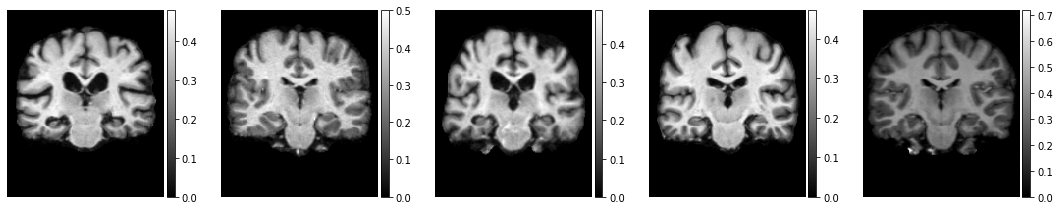

In [ ]:
# extract some brains
nb_vis = 5
idx = np.random.randint(0, x_train.shape[0], [5,])
example_digits = [f for f in x_train[idx, ...]]

# visualize
ne.plot.slices(example_digits, cmaps=['gray'], do_colorbars=True);

### Model

As with MNIST, let's create a standard VoxelMorph model trained with MSE and spatial smoothing losses.

In [ ]:
# unet
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)

# losses and loss weights
losses = ['mse', vxm.losses.Grad('l2').loss]
loss_weights = [1, 0.01]

From experimentation, we have found the Adam optimizer learning rate of `1e-4` performs better than `1e-3` for this problem.

In [ ]:
vxm_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4), loss=losses, loss_weights=loss_weights)

Luckily, we can use the same generator as before, since we're using the same format. Let's test it first.

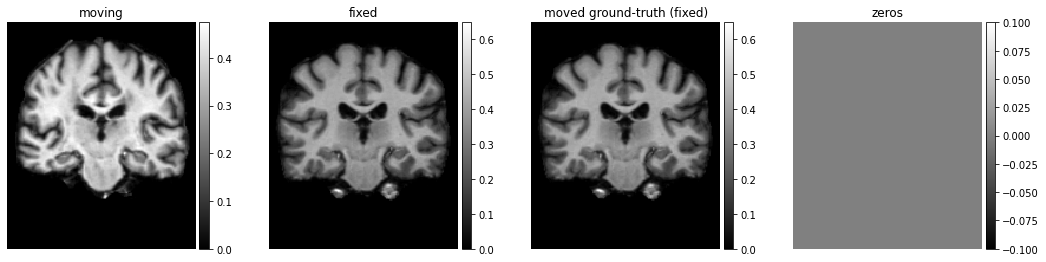

In [ ]:
# let's test it
train_generator = vxm_data_generator(x_train, batch_size=8)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample]
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

Looks good, time to **train the model**

In [ ]:
hist = vxm_model.fit_generator(train_generator, epochs=5, steps_per_epoch=5, verbose=2);

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
5/5 - 13s - loss: 0.0068 - transformer_loss: 0.0068 - flow_loss: 9.9954e-08
Epoch 2/5
5/5 - 10s - loss: 0.0069 - transformer_loss: 0.0069 - flow_loss: 1.1938e-06
Epoch 3/5
5/5 - 10s - loss: 0.0072 - transformer_loss: 0.0072 - flow_loss: 6.1821e-06
Epoch 4/5
5/5 - 10s - loss: 0.0070 - transformer_loss: 0.0070 - flow_loss: 2.6120e-05
Epoch 5/5
5/5 - 10s - loss: 0.0076 - transformer_loss: 0.0076 - flow_loss: 7.4557e-05


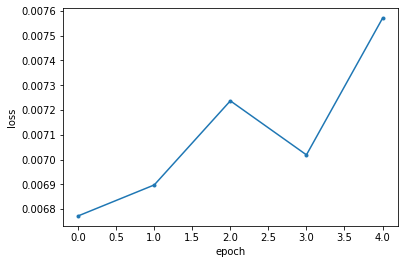

In [ ]:
# as before, let's visualize what happened
plot_history(hist)

We ran very few epochs for the purpose of the tutorial. Of course, we do not except any sort of reasonable convergence here. Let's load a model pretrained for 200 epochs:

In [ ]:
# load pretrained model weights
vxm_model.load_weights('brain_2d_smooth.h5')

Now let's see some results using validation data...

In [ ]:
# create the validation data generator
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

In [ ]:
# prediction
val_pred = vxm_model.predict(val_input)

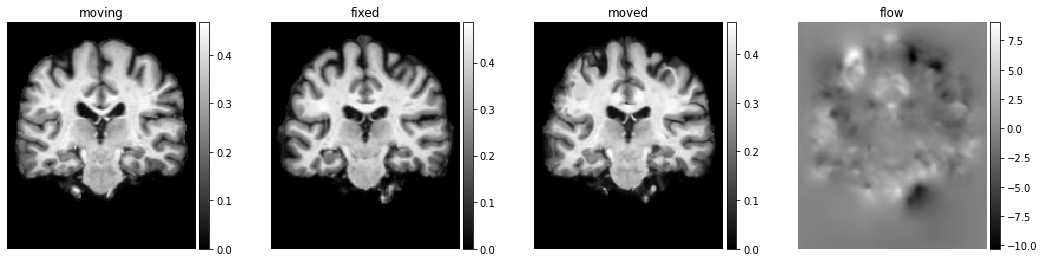

In [ ]:
# visualize registration
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

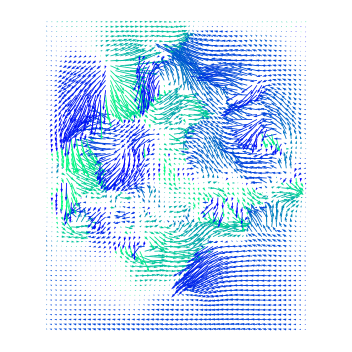

In [ ]:
# visualize flow
flow = val_pred[1].squeeze()[::3,::3]
ne.plot.flow([flow], width=5);

# Evaluation

Evaluating registration results is tricky. The first tendancy is to look at the images (as above), and conclude that if they match, The registration has succeeded.

However, this can be achieved by an optimization that only penalizes the image matching term. For example, next we compare our model with one that was trained on maximizing MSE only (without smoothness loss).

In [ ]:
# prediction from model with MSE + smoothness loss
vxm_model.load_weights('brain_2d_smooth.h5')
our_val_pred = vxm_model.predict(val_input)

# prediction from model with just MSE loss
vxm_model.load_weights('brain_2d_no_smooth.h5')
mse_val_pred = vxm_model.predict(val_input)

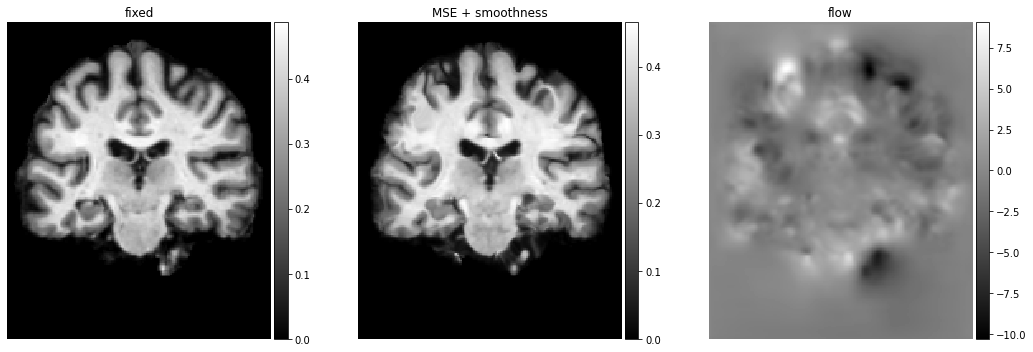

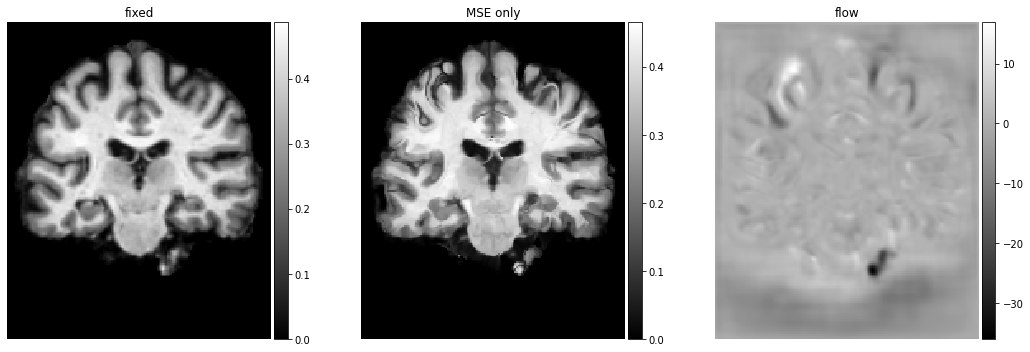

In [ ]:
# visualize MSE + smoothness model output
images = [img[0, ..., 0] for img in [val_input[1], *our_val_pred]]
titles = ['fixed', 'MSE + smoothness', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

# visualize MSE model output
images = [img[0, ..., 0] for img in [val_input[1], *mse_val_pred]]
titles = ['fixed', 'MSE only', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

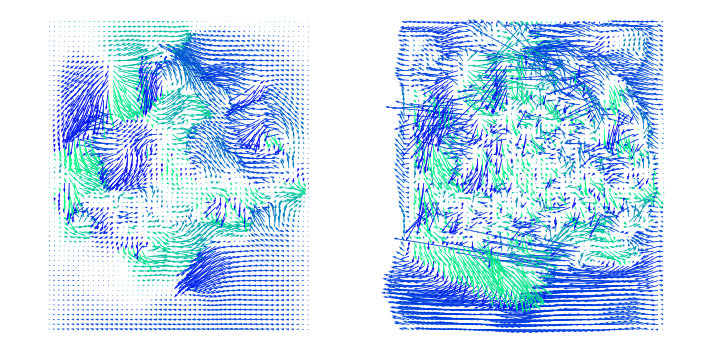

In [ ]:
ne.plot.flow([img[1].squeeze()[::3, ::3] for img in [our_val_pred, mse_val_pred]], width=10);

At first look, the MSE-only model matches the fixed image better, but we can see that it obtains a deformation field that is very noisy, unlikely to be anatomically meaningful.

What we often do isntead of use **external anotations** for evaluation one way is using anatomical segmentations.  

In the next section, we demonstrate the use of a 3D model, and show how to evaluate it with segmentations.

# 3D MRI brain scan registration

Finally, we get to 3D models, which are of particular interest in medical image analysis.

However, due to the size of the models and data, we won't be able to train a model within a short tutorial time. Instead, here we assume one has been trained, and demonstrate its use. You can train one very similar to how you trained the 2D models above.

### Model

In [ ]:
# our data will be of shape 160 x 192 x 224
vol_shape = (160, 192, 224)
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

In [ ]:
# build vxm network
vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0);

### Validation data

Let's prepare our validation data.

In [ ]:
val_volume_1 = np.load('subj1.npz')['vol']
seg_volume_1 = np.load('subj1.npz')['seg']
val_volume_2 = np.load('subj2.npz')['vol']
seg_volume_2 = np.load('subj2.npz')['seg']

val_input = [
    val_volume_1[np.newaxis, ..., np.newaxis],
    val_volume_2[np.newaxis, ..., np.newaxis]
]

Load a trained 3D model.

In [ ]:
vxm_model.load_weights('brain_3d.h5')

Now let's register.

In [ ]:
val_pred = vxm_model.predict(val_input);

In [ ]:
moved_pred = val_pred[0].squeeze()
pred_warp = val_pred[1]

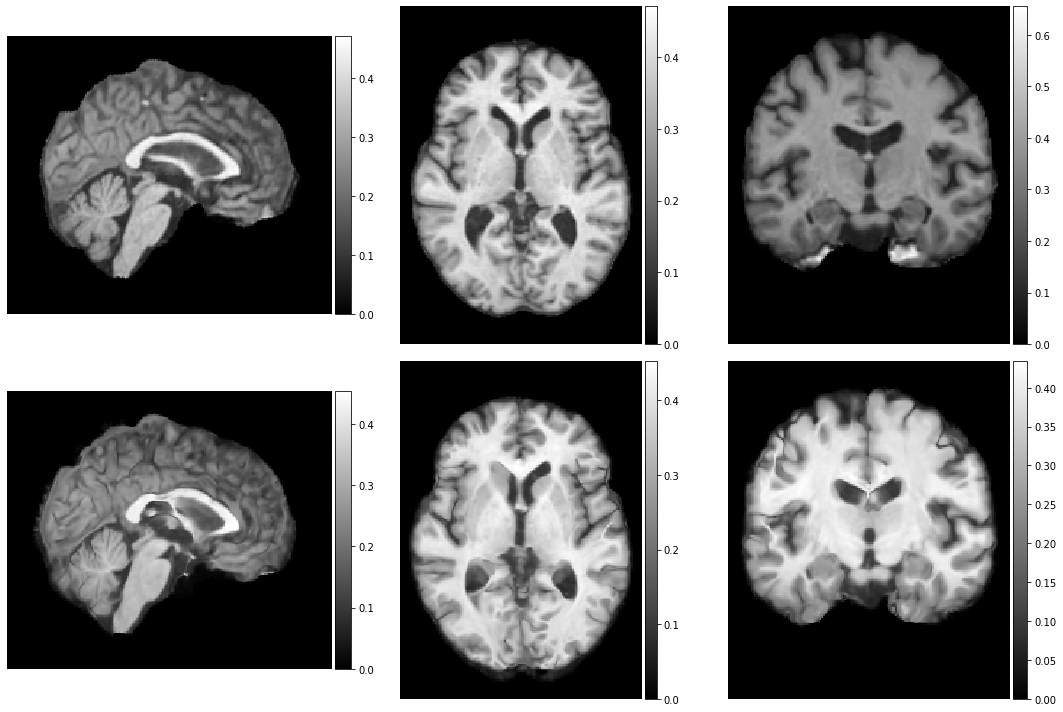

In [ ]:
mid_slices_fixed = [np.take(val_volume_2, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(moved_pred, vol_shape[d]//2, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)
ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2,3]);

Let's look at the segmentations! To do this, we'll need to warp segmentations.

In [ ]:
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

In [ ]:
warped_seg = warp_model.predict([seg_volume_1[np.newaxis,...,np.newaxis], pred_warp])

We're first going to prepare a colormap.

In [ ]:
from pystrum.pytools.plot import jitter
import matplotlib

[ccmap, scrambled_cmap] = jitter(255, nargout=2)
scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

Let's visualize the segmentations, and essentially make sure they are not crazy.

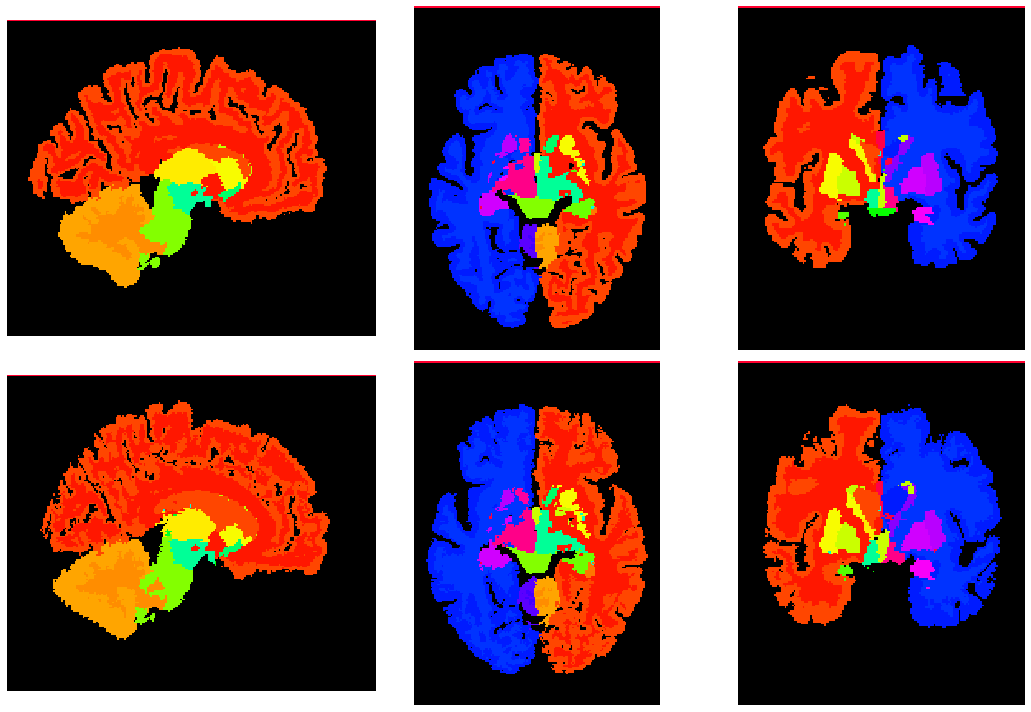

In [ ]:
mid_slices_fixed = [np.take(seg_volume_1, vol_shape[d]//1.8, axis=d) for d in range(3)]
mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d]//1.8, axis=d) for d in range(3)]
mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

slices = mid_slices_fixed + mid_slices_pred
for si, slc  in enumerate(slices):
    slices[si][0] = 255
ne.plot.slices(slices, cmaps = [ccmap], grid=[2,3]);

## Runtime

An important advantage of learning-based methods is the dramatically lowered runtime.

In [ ]:
%timeit vxm_model.predict(val_input)

1 loop, best of 3: 37.1 s per loop


In our tests, a run is 10s, for an entire 3D volume. Classically, this would take hours.